In [ ]:
!wget https://github.com/GwenTsang/RNN_text_classification/archive/refs/heads/main.zip
!unzip main.zip

--2025-11-16 17:53:57--  https://github.com/GwenTsang/RNN_text_classification/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/GwenTsang/RNN_text_classification/zip/refs/heads/main [following]
--2025-11-16 17:53:57--  https://codeload.github.com/GwenTsang/RNN_text_classification/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ]   3.67K  --.-KB/s    in 0s      

2025-11-16 17:53:58 (57.2 MB/s) - ‘main.zip’ saved [3753]

Archive:  main.zip
6429ae9c12297f991290bcd09923df2e289e8997
   creating: RNN_text_classification-main/
 extra

In [ ]:
!sudo apt-get install megatools -q
!megadl "https://mega.nz/file/iRsyERhB#C734Rj4o8AJI3SqETHtGYN9LFsPdhls6h3NndMk6EDg"

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 1s (342 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package megatools.
(Reading database ... 121703 files and directories currently ins

In [ ]:
!tar -xzf Corpus_classif.tgz

In [ ]:
%cd /content/RNN_text_classification-main

/content/RNN_text_classification-main


In [ ]:
def simple_lstm_model(num_classes: int):
    """
    Modèle LSTM empilé plus léger pour un entraînement plus rapide sur CPU
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_sequence_length=MAX_SEQ_LEN,
        name="text_vectorizer",
    )

    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBED_DIM,
            mask_zero=True,
            name="embedding",
        ),
        tf.keras.layers.SpatialDropout1D(0.2, name="spatial_dropout"),

        tf.keras.layers.LSTM(128, return_sequences=True, name="lstm_128"),
        tf.keras.layers.LSTM(64, name="lstm_64"),

        tf.keras.layers.BatchNormalization(name="bn_1"),
        tf.keras.layers.Dense(64, activation="relu", name="dense_64"),
        tf.keras.layers.Dropout(0.4, name="dropout_64"),

        tf.keras.layers.BatchNormalization(name="bn_2"),
        tf.keras.layers.Dense(32, activation="relu", name="dense_32"),
        tf.keras.layers.Dropout(0.4, name="dropout_32"),

        tf.keras.layers.Dense(num_classes, activation="softmax", name="output"),
    ])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=2e-3,
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",  # integer labels
        metrics=["accuracy"],
    )

    return model, vectorizer

In [ ]:
def train_once(
    files,
    labels,
    num_classes,
    build_model_fn,
    sampler=None,
    use_class_weights=False,
):
    X_train, X_val, y_train, y_val = train_test_split(
        files,
        labels,
        test_size=VAL_SPLIT,
        stratify=labels,
        random_state=SEED,
    )

    if sampler is not None:
        X_train, y_train = sampler(X_train, y_train, seed=SEED)

    train_ds = create_dataset(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
    )
    val_ds = create_dataset(
        X_val, y_val,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=None,
    )

    # "build_model_function" peut être aussi bien "build_bilstm_model", "build_bigru_model", etc.
    model, vectorizer = build_model_fn(num_classes)
    vectorizer.adapt(train_ds.map(lambda x, y: x))

    class_weights = compute_class_weights(y_train) if use_class_weights else None

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=make_callbacks(),
    )

    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"Validation accuracy: {val_acc:.4f}")
    plot_accuracy(history)

    return model, history

In [ ]:
DATA_DIR = "/content/Corpus_classif"

from load_data import (
    load_data,
    create_dataset,
    compute_class_weights,
    oversample_data,
)
from visualization import plot_accuracy

In [ ]:
files, labels, class_names = load_data(DATA_DIR)
num_classes = len(class_names)

In [ ]:
def simple_lstm_model(num_classes: int):
    """
    Modèle LSTM empilé plus léger pour un entraînement plus rapide sur CPU
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_sequence_length=MAX_SEQ_LEN,
        name="text_vectorizer",
    )

    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBED_DIM,
            mask_zero=True,
            name="embedding",
        ),
        tf.keras.layers.SpatialDropout1D(0.2, name="spatial_dropout"),

        tf.keras.layers.LSTM(128, return_sequences=True, name="lstm_128"),
        tf.keras.layers.LSTM(64, name="lstm_64"),

        tf.keras.layers.BatchNormalization(name="bn_1"),
        tf.keras.layers.Dense(64, activation="relu", name="dense_64"),
        tf.keras.layers.Dropout(0.4, name="dropout_64"),

        tf.keras.layers.BatchNormalization(name="bn_2"),
        tf.keras.layers.Dense(32, activation="relu", name="dense_32"),
        tf.keras.layers.Dropout(0.4, name="dropout_32"),

        tf.keras.layers.Dense(num_classes, activation="softmax", name="output"),
    ])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=2e-3,
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",  # integer labels
        metrics=["accuracy"],
    )

    return model, vectorizer

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from load_data import (
    load_data,
    create_dataset,
    compute_class_weights,
    oversample_data,
)
from visualization import plot_accuracy

VOCAB_SIZE   = 30_000
EMBED_DIM    = 128
MAX_SEQ_LEN  = 500
LEARNING_RATE = 1e-3
BATCH_SIZE   = 512
VAL_SPLIT    = 0.2
EPOCHS       = 20
PATIENCE     = 4
SEED         = 42


def build_bilstm_model(num_classes: int):
    """ Bidirectionnal LSTM text classification model."""
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_sequence_length=MAX_SEQ_LEN,
    )

    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, dropout=0.3)
        ),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model, vectorizer


def make_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=PATIENCE // 2,
            verbose=1,
        ),
    ]

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.1655 - loss: 2.2160 - val_accuracy: 0.3686 - val_loss: 1.9341 - learning_rate: 0.0020
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.3704 - loss: 1.4854 - val_accuracy: 0.3886 - val_loss: 1.9124 - learning_rate: 0.0020
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5156 - loss: 1.2315 - val_accuracy: 0.5329 - val_loss: 1.8807 - learning_rate: 0.0020
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6085 - loss: 1.0201 - val_accuracy: 0.5329 - val_loss: 1.8557 - learning_rate: 0.0020
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6693 - loss: 0.8593 - val_accuracy: 0.6329 - val_loss: 1.8112 - learning_rate: 0.0020
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7395 - loss: 0.7164 - val_accuracy: 0.6243 - val_loss: 1.7402 - learning_rate: 0.0020
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7961 - loss: 0.5496 - val_accuracy: 

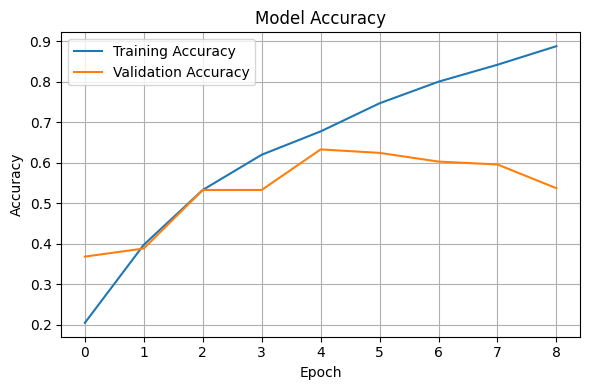

In [ ]:
model_lstm_small, history_lstm_small = train_once(
    files=files,
    labels=labels,
    num_classes=num_classes,
    build_model_fn=simple_lstm_model,
    sampler=None,
    use_class_weights=True,
)

Il semble que le modèle overfit

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.4287 - loss: 1.5633 - val_accuracy: 0.4871 - val_loss: 1.8200 - learning_rate: 0.0020
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8218 - loss: 0.6279 - val_accuracy: 0.7543 - val_loss: 1.4922 - learning_rate: 0.0020
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9393 - loss: 0.2634 - val_accuracy: 0.7600 - val_loss: 1.2700 - learning_rate: 0.0020
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9713 - loss: 0.1429 - val_accuracy: 0.7657 - val_loss: 0.9631 - learning_rate: 0.0020
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9829 - loss: 0.0911 - val_accuracy: 0.8043 - val_loss: 0.7224 - learning_rate: 0.0020
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9862 - loss: 0.0785 - val_accuracy: 0.7843 - val_loss: 0.7351 - learning_rate: 0.0020
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9809 - loss: 0.0811 - 

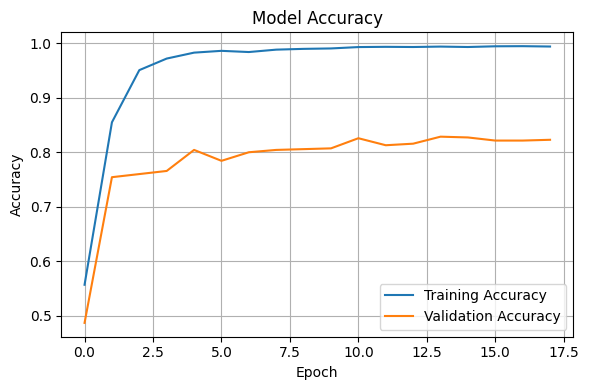

In [ ]:
model_lstm_small, history_lstm_small = train_once(
    files=files,
    labels=labels,
    num_classes=num_classes,
    build_model_fn=simple_lstm_model,
    sampler=oversample_data,
    use_class_weights=False,
)

In [ ]:
import os
import random
import itertools
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from load_data import load_data, oversample_data, create_dataset

# -------------------------------------------------------------------
# Config
# -------------------------------------------------------------------
DATA_DIR       = DATA_DIR  # reuse your existing variable, or set a path string
VAL_SPLIT      = 0.2
EPOCHS_SEARCH  = 8        # fewer epochs for CPU
PATIENCE       = 2
SEARCH_SEEDS   = (42, 123, 2024)  # 3 seeds per configuration

# -------------------------------------------------------------------
# Utilities
# -------------------------------------------------------------------
def set_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def build_simple_lstm(
    num_classes: int,
    vocab_size: int,
    max_seq_len: int,
    embedding_dim: int,
    dropout_rate: float,
):
    """Simple LSTM text classifier (CPU-friendly). Returns (model, vectorizer)."""
    tf.keras.backend.clear_session()

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=max_seq_len,
        name="text_vectorizer",
    )

    model = tf.keras.Sequential(
        [
            vectorizer,
            tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                mask_zero=True,
                name="embedding",
            ),
            tf.keras.layers.SpatialDropout1D(dropout_rate, name="spatial_dropout"),
            tf.keras.layers.LSTM(64, name="lstm_64"),
            tf.keras.layers.Dense(32, activation="relu", name="dense_32"),
            tf.keras.layers.Dropout(dropout_rate, name="dropout_dense"),
            tf.keras.layers.Dense(num_classes, activation="softmax", name="output"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model, vectorizer


def train_single_run(config, seed, files, labels, num_classes):
    """
    Train one LSTM model with a given hyperparameter config and seed.
    Uses oversampling defined in load_data.py.
    Returns validation accuracy.
    """
    set_seeds(seed)

    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        files,
        labels,
        test_size=VAL_SPLIT,
        stratify=labels,
        random_state=seed,
    )

    # Oversampling
    X_train, y_train = oversample_data(X_train, y_train, seed=seed)

    # Datasets
    train_ds = create_dataset(
        X_train,
        y_train,
        batch_size=config["batch_size"],
        shuffle=True,
        seed=seed,
    )
    val_ds = create_dataset(
        X_val,
        y_val,
        batch_size=config["batch_size"],
        shuffle=False,
        seed=None,
    )

    # Model
    model, vectorizer = build_simple_lstm(
        num_classes=num_classes,
        vocab_size=config["vocab_size"],
        max_seq_len=config["max_seq_len"],
        embedding_dim=config["embedding_dim"],
        dropout_rate=config["dropout_rate"],
    )

    # Adapt vectorizer
    vectorizer.adapt(train_ds.map(lambda x, y: x))

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=0,
        )
    ]

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_SEARCH,
        callbacks=callbacks,
        verbose=0,  # set to 1 if you want detailed logs
    )

    # Evaluate
    _, val_acc = model.evaluate(val_ds, verbose=0)
    return float(val_acc)


def run_hparam_search(num_configs: int = 100, seeds=SEARCH_SEEDS):
    """
    Run random search over hyperparameters.
    Tests `num_configs` configs; for each, trains with all given `seeds`.
    Returns (results_list, best_config_dict).
    """
    # Load data once
    files, labels, class_names = load_data(DATA_DIR)
    num_classes = len(class_names)

    # Search space
    embedding_dims = [64, 128, 256]
    batch_sizes    = [64, 128, 256, 512]
    vocab_sizes    = [10_000, 20_000, 30_000]
    max_seq_lens   = [200, 300, 400, 500]
    dropout_rates  = [0.2, 0.3, 0.4]

    all_configs = [
        {
            "embedding_dim": emb,
            "batch_size": batch,
            "vocab_size": vocab,
            "max_seq_len": max_len,
            "dropout_rate": dr,
        }
        for emb, batch, vocab, max_len, dr in itertools.product(
            embedding_dims, batch_sizes, vocab_sizes, max_seq_lens, dropout_rates
        )
    ]

    # Randomly pick 100 configurations
    num_configs = min(num_configs, len(all_configs))
    random.shuffle(all_configs)
    search_configs = all_configs[:num_configs]

    results = []
    best_config = None
    best_avg_acc = -1.0

    for idx, cfg in enumerate(search_configs, start=1):
        seed_accs = []
        for s in seeds:
            val_acc = train_single_run(cfg, s, files, labels, num_classes)
            seed_accs.append(val_acc)

        avg_acc = float(np.mean(seed_accs))

        cfg_result = {
            "config_index": idx,
            **cfg,
            "seed_accs": seed_accs,
            "avg_val_acc": avg_acc,
        }
        results.append(cfg_result)

        if avg_acc > best_avg_acc:
            best_avg_acc = avg_acc
            best_config = cfg_result

        print(f"[{idx}/{len(search_configs)}] config={cfg}  avg_val_acc={avg_acc:.4f}")

    print("\nBest configuration found:")
    print(best_config)

    return results, best_config


In [ ]:
import os
import random
import itertools
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from load_data import load_data, oversample_data, create_dataset

# -------------------------------------------------------------------
# Config
# -------------------------------------------------------------------
DATA_DIR       = DATA_DIR  # reuse your existing variable, or set a path string
VAL_SPLIT      = 0.2
EPOCHS_SEARCH  = 8        # fewer epochs for CPU
PATIENCE       = 2
SEARCH_SEEDS   = (42, 123, 2024)  # 3 seeds per configuration

# -------------------------------------------------------------------
# Utilities
# -------------------------------------------------------------------
def set_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def build_simple_lstm(
    num_classes: int,
    vocab_size: int,
    max_seq_len: int,
    embedding_dim: int,
    dropout_rate: float,
):
    """Simple LSTM text classifier (CPU-friendly). Returns (model, vectorizer)."""
    tf.keras.backend.clear_session()

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=max_seq_len,
        name="text_vectorizer",
    )

    model = tf.keras.Sequential(
        [
            vectorizer,
            tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                mask_zero=True,
                name="embedding",
            ),
            tf.keras.layers.SpatialDropout1D(dropout_rate, name="spatial_dropout"),
            tf.keras.layers.LSTM(64, name="lstm_64"),
            tf.keras.layers.Dense(32, activation="relu", name="dense_32"),
            tf.keras.layers.Dropout(dropout_rate, name="dropout_dense"),
            tf.keras.layers.Dense(num_classes, activation="softmax", name="output"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model, vectorizer


def train_single_run(config, seed, files, labels, num_classes):
    """
    Train one LSTM model with a given hyperparameter config and seed.
    Uses oversampling defined in load_data.py.
    Returns validation accuracy.
    """
    set_seeds(seed)

    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        files,
        labels,
        test_size=VAL_SPLIT,
        stratify=labels,
        random_state=seed,
    )

    # Oversampling
    X_train, y_train = oversample_data(X_train, y_train, seed=seed)

    # Datasets
    train_ds = create_dataset(
        X_train,
        y_train,
        batch_size=config["batch_size"],
        shuffle=True,
        seed=seed,
    )
    val_ds = create_dataset(
        X_val,
        y_val,
        batch_size=config["batch_size"],
        shuffle=False,
        seed=None,
    )

    # Model
    model, vectorizer = build_simple_lstm(
        num_classes=num_classes,
        vocab_size=config["vocab_size"],
        max_seq_len=config["max_seq_len"],
        embedding_dim=config["embedding_dim"],
        dropout_rate=config["dropout_rate"],
    )

    # Adapt vectorizer
    vectorizer.adapt(train_ds.map(lambda x, y: x))

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=0,
        )
    ]

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_SEARCH,
        callbacks=callbacks,
        verbose=0,
    )

    # Evaluate
    _, val_acc = model.evaluate(val_ds, verbose=0)
    return float(val_acc)


def run_hparam_search(num_configs: int = 100, seeds=SEARCH_SEEDS):
    """
    Run random search over hyperparameters.
    Tests `num_configs` configs; for each, trains with all given `seeds`.
    Returns (results_list, best_config_dict).
    """
    # Load data once
    files, labels, class_names = load_data(DATA_DIR)
    num_classes = len(class_names)

    # Search space
    embedding_dims = [64, 128, 256]
    batch_sizes    = [64, 128, 256, 512]
    vocab_sizes    = [10_000, 20_000, 30_000]
    max_seq_lens   = [200, 300, 400, 500]
    dropout_rates  = [0.2, 0.3, 0.4]

    all_configs = [
        {
            "embedding_dim": emb,
            "batch_size": batch,
            "vocab_size": vocab,
            "max_seq_len": max_len,
            "dropout_rate": dr,
        }
        for emb, batch, vocab, max_len, dr in itertools.product(
            embedding_dims, batch_sizes, vocab_sizes, max_seq_lens, dropout_rates
        )
    ]

    # Randomly pick 100 configurations
    num_configs = min(num_configs, len(all_configs))
    random.shuffle(all_configs)
    search_configs = all_configs[:num_configs]

    results = []
    best_config = None
    best_avg_acc = -1.0

    for idx, cfg in enumerate(search_configs, start=1):
        seed_accs = []
        for s in seeds:
            val_acc = train_single_run(cfg, s, files, labels, num_classes)
            seed_accs.append(val_acc)

        avg_acc = float(np.mean(seed_accs))

        cfg_result = {
            "config_index": idx,
            **cfg,
            "seed_accs": seed_accs,
            "avg_val_acc": avg_acc,
        }
        results.append(cfg_result)

        if avg_acc > best_avg_acc:
            best_avg_acc = avg_acc
            best_config = cfg_result

        print(f"[{idx}/{len(search_configs)}] config={cfg}  avg_val_acc={avg_acc:.4f}")

    print("\nBest configuration found:")
    print(best_config)

    return results, best_config


In [ ]:
results, best_config = run_hparam_search(num_configs=100)

[1/100] config={'embedding_dim': 128, 'batch_size': 64, 'vocab_size': 30000, 'max_seq_len': 200, 'dropout_rate': 0.3}  avg_val_acc=0.8562
[2/100] config={'embedding_dim': 128, 'batch_size': 256, 'vocab_size': 10000, 'max_seq_len': 500, 'dropout_rate': 0.2}  avg_val_acc=0.8538
[3/100] config={'embedding_dim': 128, 'batch_size': 128, 'vocab_size': 30000, 'max_seq_len': 200, 'dropout_rate': 0.4}  avg_val_acc=0.8600
[4/100] config={'embedding_dim': 256, 'batch_size': 128, 'vocab_size': 30000, 'max_seq_len': 300, 'dropout_rate': 0.4}  avg_val_acc=0.8476
[5/100] config={'embedding_dim': 256, 'batch_size': 128, 'vocab_size': 10000, 'max_seq_len': 500, 'dropout_rate': 0.4}  avg_val_acc=0.8476
[6/100] config={'embedding_dim': 64, 'batch_size': 256, 'vocab_size': 30000, 'max_seq_len': 500, 'dropout_rate': 0.3}  avg_val_acc=0.8495
[7/100] config={'embedding_dim': 128, 'batch_size': 128, 'vocab_size': 10000, 'max_seq_len': 300, 'dropout_rate': 0.3}  avg_val_acc=0.8510
[8/100] config={'embedding_di